This notebook is to implement the algorithm developed in https://www.nature.com/articles/s41598-020-60321-x where they outline a method to simulate non-unitary channels (here, the AD channel is implemented) using unitary gates courtesy of the Sz.-Nagy dilation theorem.

Here, an AD channel is implemented. The Kraus operators for this channel are non-unitary. Using the dilation theorem, its corresponding unitary gates are found and the time-evolution of an initial density matrix is calculated. Details of this are worked out in my iPad and in the paper. 

To convert this numerical algorithm to a quantum algorithm that can be implemented on a quantum circuit, we use the theorem that says a unitary gate can be decomposed to a sequence of two-level unitary gates. This is how the dilations are mapped to unitary gates that can be implemented on a quantum circuit. Numerical calculation has been done on iPad and results plotted in the paper. 

The supplementary information (SI) part of the paper gives the rest of the circuits ready-made. In this notebook, I'm implementing those circuits to reproduce their results.

My initial state is supposed to be 

$\begin{equation}\rho = \frac{1}{4}\begin{bmatrix} 1 & 1 \\ 1 & 3 \end{bmatrix}\end{equation}$ with the composition $\begin{equation}\rho = \frac{1}{2}(|0\rangle\langle 0| + |+\rangle\langle+|)\end{equation}$.

The operator-sum representation of the time-evolved density matrix is given as,

$\begin{equation}
    \rho(t) = M_0 \rho M_0^\dag + M_1 \rho M_1^\dag
\end{equation}$

where 

$\begin{equation}
    M_0 = \begin{bmatrix} 1 & 0 \\ 0 & \sqrt{e^{-\gamma t}}\end{bmatrix} 
\end{equation}$
$\begin{equation}
    M_1 = \begin{bmatrix} 0 & \sqrt{1-e^{-\gamma t}} \\ 0 & 0 \end{bmatrix}
\end{equation}$

The 1-dilation is defined as $U_A = \begin{bmatrix} A & D_{A^\dag} \\ D_A & -A^\dag \end{bmatrix}$ with the defect operator of $A$ defined as $D_A = \sqrt{1-A^\dag A}$.

The decomposition of $U_{M_0}v_1$ and others into 1-qubit and 2-qubit unitary gates can be performed and displayed in the form of a quantum circuit. The paper gives these circuits and I try to implement it here.

In [1]:
from qiskit import *

In [22]:
def u0v1(qc: QuantumCircuit, angle_factor):

    qc.u(-1.08*angle_factor,0,0,1)
    qc.h(1)
    qc.cx(1,0)
    qc.h(1)
    qc.u(1.08*angle_factor,0,0,1)
    qc.h(1)
    qc.cx(1,0)
    qc.h(1)
    qc.h(0)
    qc.z(1)
    # qc.measure(0,0)
    # qc.measure(1,1)
    return qc

def u0v2(qc: QuantumCircuit, angle_factor):

    qc.x(0)
    qc.u(-1.08*angle_factor,0,0,1)
    qc.h(0)
    qc.h(1)
    qc.cx(1,0)
    qc.h(1)
    qc.u(1.08*angle_factor,0,0,1)
    qc.h(1)
    qc.cx(1,0)
    qc.h(1)
    qc.h(0)
    qc.z(1)
    # qc.measure(0,0)
    # qc.measure(1,1)

    return qc

def u1v1(qc: QuantumCircuit, angle_factor):

    qc.h(0)
    qc.cx(1,0)
    qc.h(0)
    qc.x(1)
    qc.u(-1.08*angle_factor,0,0,1)
    qc.h(1)
    qc.cx(1,0)
    qc.h(1)
    qc.u(1.08*angle_factor,0,0,1)
    qc.h(1)
    qc.cx(1,0)
    qc.h(1)
    qc.h(0)
    qc.x(1)
    qc.cx(1,0)
    # qc.measure(0,0)
    qc.x(1)
    # qc.measure(1,1)

    return qc

def u1v2(qc: QuantumCircuit, angle_factor):

    qc.x(0)
    qc.cx(1,0)
    qc.h(0)
    qc.x(1)
    qc.u(-1.08*angle_factor,0,0,1)
    qc.h(1)
    qc.cx(1,0)
    qc.h(1)
    qc.u(1.08*angle_factor,0,0,1)
    qc.h(1)
    qc.cx(1,0)
    qc.h(1)
    qc.h(0)
    qc.x(1)
    qc.cx(1,0)
    # qc.measure(0,0)
    qc.x(1)
    # qc.measure(1,1)
    
    return qc


Numerical simulation of $U_{M_k}v_i$ from $t = 0$ to $t = 1000$ ps with $\Delta t = 10$ ps, $\gamma=1.52 \text{ x } 10^9 s^{-1}$ as the damping rate. This means I apply the $U_{M_k}$ gate, which is a function of time, but time replaced with $\Delta t$ and apply it $(t_f - t_i)/\Delta t$ times.

n_steps = 1000


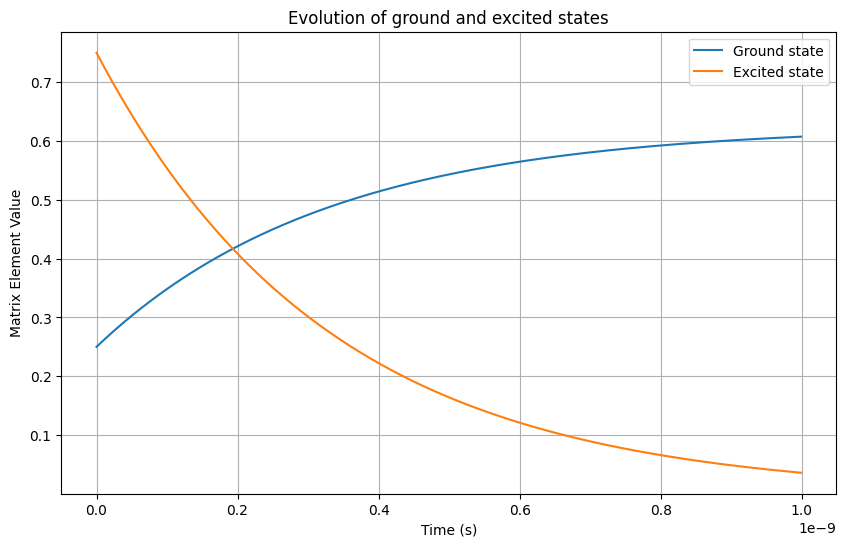

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Pertinent variables

gamma = 1.52*10**9
total_time = 1000*10**(-12)
delta_t = 1*10**(-12)
n_steps = int(total_time/delta_t)
print(f"n_steps = {n_steps}")

# Kraus operators for the amplitude damping channel

M_0 = np.array([[1, 0], [0, np.exp(-gamma * delta_t)]])
M_1 = np.array([[0, np.sqrt(1 - np.exp(-gamma * delta_t))], [0, 0]])

M_0_dag = M_0.conj().T
M_1_dag = M_1.conj().T

I = np.eye(2)

D_M_0 = np.array([[0, 0], [0, np.sqrt(1 - np.exp(-gamma * delta_t))]])
D_M_1 = np.array([[1, 0], [0, np.exp(-gamma * delta_t)]])

D_Mdag_0 = np.array([[0, 0], [0, np.sqrt(1 - np.exp(-gamma * delta_t))]])
D_Mdag_1 = np.array([[1, 0], [0, np.exp(-gamma * delta_t)]])


# 1-dilations of the Kraus operators (non-unitary)

U_M_0 = np.block([[M_0, D_Mdag_0], [D_M_0, -M_0_dag]])
U_M_1 = np.block([[M_1, D_Mdag_1], [D_M_1, -M_1_dag]])

# Define vectors v_1 and v_2
v_1 = np.array([0, 1, 0, 0])
v_2 = (1 / np.sqrt(2)) * np.array([1, 1, 0, 0])
p1 = 0.5
p2 = 0.5

# Initialize density matrices
rho_0 = np.outer(v_1, v_1)  # rho_0 = |v_1><v_1|
rho_1 = np.outer(v_2, v_2)  # rho_1 = |v_2><v_2|

# Initialize the final density matrix
final_state = p1 * rho_0 + p2 * rho_1

# test_vec0 = np.array([1,0,0,0])
# test_vec1 = np.array([0,1,0,0])

# rho_00 = np.outer(test_vec0, test_vec0)
# rho_11 = np.outer(test_vec1, test_vec1)

# rho_00_evolved = U_M_0 @ rho_00 @ U_M_0.T + U_M_1 @ rho_00 @ U_M_1.T
# print(rho_00_evolved)

# rho_00_evolved[2:, :] = 0  # Zero out rows 2 and beyond
# rho_00_evolved[:, 2:] = 0  # Zero out columns 2 and beyond

# rho_11_evolved = U_M_0 @ rho_11 @ U_M_0.T + U_M_1 @ rho_11 @ U_M_1.T
# print(rho_11_evolved)

# rho_11_evolved[2:, :] = 0  # Zero out rows 2 and beyond
# rho_11_evolved[:, 2:] = 0  # Zero out columns 2 and beyond

# rho_00_evolved = U_M_0 @ rho_00_evolved @ U_M_0.T + U_M_1 @ rho_00_evolved @ U_M_1.T
# print(rho_00_evolved)

# rho_11_evolved = U_M_0 @ rho_11_evolved @ U_M_0.T + U_M_1 @ rho_11_evolved @ U_M_1.T
# print(rho_11_evolved)


# Store diagonal elements for plotting
elements_00 = [final_state[0, 0].real]  # Ground state population
elements_11 = [final_state[1, 1].real]  # Excited state population

time_steps = [step * delta_t for step in range(n_steps)]

rho_0_evolved = rho_0
rho_1_evolved = rho_1

# Time evolution
for step in range(n_steps - 1):
    # Evolve each density matrix with Kraus operators
    rho_0_evolved = (
        U_M_0 @ rho_0_evolved @ U_M_0.T + U_M_1 @ rho_0_evolved @ U_M_1.T
    )
    rho_1_evolved = (
        U_M_0 @ rho_1_evolved @ U_M_0.T + U_M_1 @ rho_1_evolved @ U_M_1.T
    )
    
    # Update the total final density matrix
    final_state = p1 * rho_0_evolved + p2 * rho_1_evolved

    rho_0_evolved[2:, :] = 0  # Zero out rows 2 and beyond
    rho_0_evolved[:, 2:] = 0  # Zero out columns 2 and beyond
    rho_1_evolved[2:, :] = 0  # Zero out rows 2 and beyond
    rho_1_evolved[:, 2:] = 0  # Zero out columns 2 and beyond

    # Append diagonal elements to track populations
    elements_00.append(final_state[0, 0].real)
    elements_11.append(final_state[1, 1].real)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps, elements_00, label="Ground state")
plt.plot(time_steps, elements_11, label="Excited state")
plt.xlabel("Time (s)")
plt.ylabel("Matrix Element Value")
plt.title("Evolution of ground and excited states")
plt.legend()
plt.grid()
plt.show()


#   Lesson here: After every timestep application of U, I had to retain only the upper left block of the matrix before I applied U again. This looks akin to projection back to H after every application of H.

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.01
0.011
0.012
0.013000000000000001
0.014
0.015
0.016
0.017
0.018000000000000002
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026000000000000002
0.027
0.028
0.029
0.03
0.031
0.032
0.033
0.034
0.035
0.036000000000000004
0.037
0.038
0.039
0.04
0.041
0.042
0.043000000000000003
0.044
0.045
0.046
0.047
0.048
0.049
0.05
0.051000000000000004
0.052000000000000005
0.053
0.054
0.055
0.056
0.057
0.058
0.059000000000000004
0.06
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.07100000000000001
0.07200000000000001
0.073
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.08600000000000001
0.08700000000000001
0.088
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1
0.101
0.10200000000000001
0.10300000000000001
0.10400000000000001
0.105
0.106
0.107
0.108
0.109
0.11
0.111
0.112
0.113
0.114
0.115
0.116
0.117
0.11800000000000001
0.11900000000000001
0.12
0.121
0.122
0.123
0.124
0.125
0.

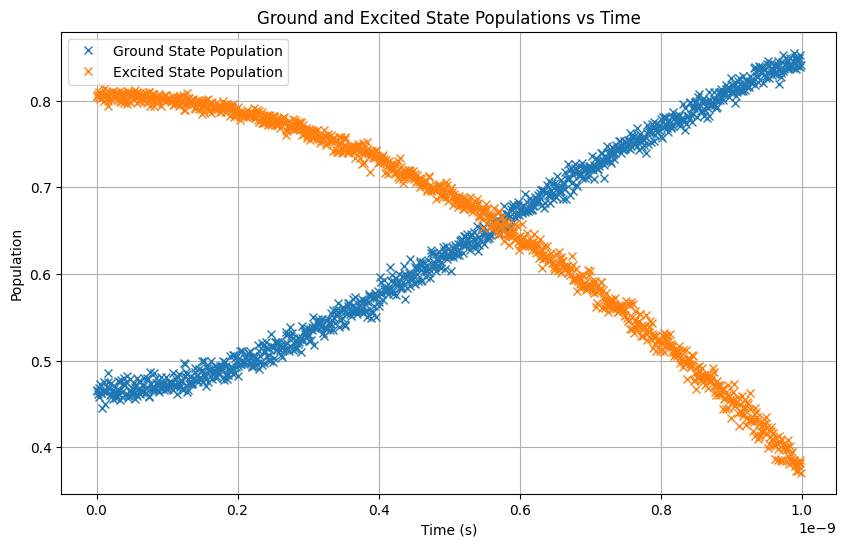

In [23]:
import matplotlib.pyplot as plt
from qiskit import *
from qiskit_aer import AerSimulator
import scipy.linalg as sp
import numpy as np

gamma = 1.52*10**9
total_time = 1000*10**(-12)
delta_t = 1*10**(-12)
n_steps = int(total_time/delta_t)
rho = np.array([[1/4,1/4],[1/4,3/4]])
rho_norm = sp.norm(rho)

qc_v_01 = QuantumCircuit(2,2)   # Naming convention: v_gate,vector. Here, v_01 means U_M0 applied to vector v1.
qc_v_11 = QuantumCircuit(2,2)
qc_v_02 = QuantumCircuit(2,2)
qc_v_12 = QuantumCircuit(2,2)

# --------------------------------------------
#   APPLYING GATES TO EVOLVE THE KET
# --------------------------------------------

qc_01 = qc_v_01.copy()
qc_11 = qc_v_11.copy()
qc_02 = qc_v_02.copy()
qc_12 = qc_v_12.copy()

simulator = AerSimulator(method="statevector")
n_shots = 1024

# Create lists to store the population data
ground_populations = []
excited_populations = []

for step in range(n_steps):
    qc_v_01 = qc_01.copy()
    qc_v_11 = qc_11.copy()
    qc_v_02 = qc_02.copy()
    qc_v_12 = qc_12.copy()

    angle_factor = np.exp(-gamma * (step * delta_t))
    angle_factor = (step+1)*(delta_t/total_time)
    print(angle_factor)

    qc_v_01 = u0v1(qc_v_01, angle_factor)
    qc_v_11 = u1v1(qc_v_11, angle_factor)
    qc_v_02 = u0v2(qc_v_02, angle_factor)
    qc_v_12 = u1v2(qc_v_12, angle_factor)

    qc_v_01.measure([0,1],[0,1])
    qc_v_11.measure([0,1],[0,1])               
    qc_v_02.measure([0,1],[0,1])
    qc_v_12.measure([0,1],[0,1])        

    qc_v_01 = transpile(qc_v_01)
    result_01 = simulator.run(qc_v_01, shots=n_shots).result()
    counts_01 = result_01.get_counts(qc_v_01)

    qc_v_11 = transpile(qc_v_11)
    result_11 = simulator.run(qc_v_11, shots=n_shots).result()
    counts_11 = result_11.get_counts(qc_v_11)

    qc_v_02 = transpile(qc_v_02)
    result_02 = simulator.run(qc_v_02, shots=n_shots).result()
    counts_02 = result_02.get_counts(qc_v_02)

    qc_v_12 = transpile(qc_v_12)
    result_12 = simulator.run(qc_v_12, shots=n_shots).result()
    counts_12 = result_12.get_counts(qc_v_12)

    filtered_counts_01 = {key: counts_01.get(key, 0) for key in ['00', '01']}
    filtered_counts_11 = {key: counts_11.get(key, 0) for key in ['00', '01']}
    filtered_counts_02 = {key: counts_02.get(key, 0) for key in ['00', '01']}
    filtered_counts_12 = {key: counts_12.get(key, 0) for key in ['00', '01']}

    ground_population = np.sqrt((0.5 / n_shots) * rho_norm * (
        filtered_counts_01.get('00', 0) +
        filtered_counts_11.get('00', 0) +
        filtered_counts_02.get('00', 0) +
        filtered_counts_12.get('00', 0)
    ))

    excited_population = np.sqrt((0.5 / n_shots) * rho_norm * (
        filtered_counts_01.get('01', 0) +
        filtered_counts_11.get('01', 0) +
        filtered_counts_02.get('01', 0) +
        filtered_counts_12.get('01', 0)
    ))

    # Store the populations in the lists
    ground_populations.append(ground_population)
    excited_populations.append(excited_population)

# Now plot the data
time_steps = [i * delta_t for i in range(n_steps)]


plt.figure(figsize=(10, 6))

plt.plot(time_steps, ground_populations, marker = "x", linestyle = "None", label="Ground State Population")
plt.plot(time_steps, excited_populations, marker = "x", linestyle = "None", label="Excited State Population")
plt.xlabel('Time (s)')
plt.ylabel('Population')
plt.legend()
plt.title('Ground and Excited State Populations vs Time')
plt.grid(True)
plt.show()

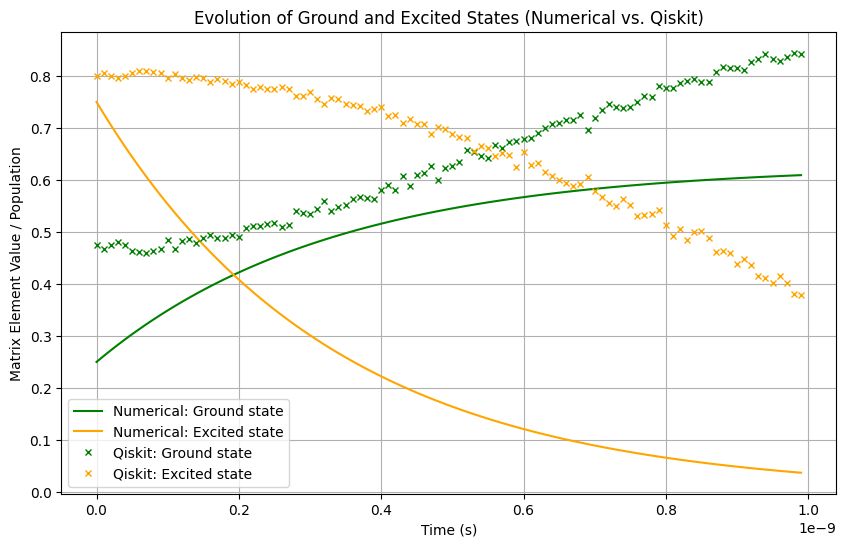

In [7]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot the results from the Kraus operators
plt.plot(time_steps, elements_00, label="Numerical: Ground state", color = "green", markersize=4)
plt.plot(time_steps, elements_11, label="Numerical: Excited state", color = "orange", markersize=4)

# Plot the results from Qiskit simulations
plt.plot(time_steps, ground_populations, label="Qiskit: Ground state", marker = "x", linestyle="None", color = "green", markersize=4)
plt.plot(time_steps, excited_populations, label="Qiskit: Excited state", marker = "x", linestyle="None", color = "orange", markersize=4)

# Configure the plot
plt.xlabel("Time (s)")
plt.ylabel("Matrix Element Value / Population")
plt.title("Evolution of Ground and Excited States (Numerical vs. Qiskit)")
plt.legend()
plt.grid()
plt.show()

In [2]:
import numpy as np
import scipy.linalg as sp
import matplotlib.pyplot as plt
import qiskit
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator

In [3]:
#defining the initial density matrix rho
rho = np.zeros((2,2),'complex') 
rho[0,0]=1/4
rho[0,1]=1/4
rho[1,0]=1/4
rho[1,1]=3/4
gamma=1.52e9# gamma is the spontaneous emission rate

iden=np.eye(2)
iden2= np.eye(4)

#flattening or vectorize the density matrix
rho_norm=sp.norm(rho)
rho_flat= rho.flatten()/rho_norm
#defining the Kraus operators
def k_0(x):    
        k = np.zeros((2,2),'complex')
        k[0,0]=1
        k[0,1]=0
        k[1,0]=0
        k[1,1]= np.sqrt(np.exp(-gamma*x))
        return k
def k_1(x):    
        k = np.zeros((2,2),'complex')
        k[0,0]=0
        k[0,1]=np.sqrt(1-np.exp(-gamma*x))
        k[1,0]=0
        k[1,1]=0
        return k

In [4]:
#defining the function for dilation
def udil(k):
#first and second stands for the M and N, i.e. Kraus and its complex conjugate   
    first= np.kron(k,iden)
    kc=k.conjugate()  #complex conjugate of k
    second= np.kron(iden,kc)
    fcon = (first.conjugate()).T
    scon = (second.conjugate()).T
    #calculate the defect operators of each Kraus operators
    fdef = sp.sqrtm(iden2-np.dot(fcon,first))
    sdef = sp.sqrtm(iden2 -np.dot(scon,second))
    fcondef = sp.sqrtm(iden2-np.dot(first,fcon))
    scondef = sp.sqrtm(iden2-np.dot(second,scon))
    #2-dilation process 
    Ufirst= np.block([[first, np.zeros((4,4)),fcondef,np.zeros((4,4))],
    [fdef,np.zeros((4,4)),-fcon,np.zeros((4,4))],
    [np.zeros((4,4)),np.eye(4),np.zeros((4,4)),np.zeros((4,4))],
    [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4)),np.eye(4)]])
    
    Usecond=np.block([[second, np.zeros((4,4)),scondef,np.zeros((4,4))],
    [sdef,np.zeros((4,4)),-scon,np.zeros((4,4))],
    [np.zeros((4,4)),np.eye(4),np.zeros((4,4)),np.zeros((4,4))],
    [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4)),np.eye(4)]])

    ufre=np.reshape(Ufirst,(1,256))
    usec=np.reshape(Usecond,(1,256))
    #returning the unitaries for both the Kraus operator and its complex conjugate
    return ufre,usec 

In [14]:
#defining lists used to store the results
rho_at_t=np.zeros((1000,2), "complex")
time=np.zeros((1000,1),)
udil01=np.zeros((1000,256),"complex")
udil02=np.zeros((1000,256),"complex")
udil11=np.zeros((1000,256),"complex")
udil12=np.zeros((1000,256),"complex")
# assigning the time-steps
for t in range(0,1000):
    tt=t*10**-12
    k0=k_0(tt)
    k1=k_1(tt)
    udil01[t],udil02[t] = udil(k0)    
    udil11[t],udil12[t] = udil(k1)

shots = 2000
#create dictionaries to store the results. three binary digits due to 8*8 matrix needs three qubits
result = {'0000': 0, '0001': 0, '0010': 0, '0011': 0,'0100': 0, '0101': 0, '0110': 0, '0111': 0, '1000': 0, '1001': 0, '1010': 0, '1011': 0,'1100': 0, '1101': 0, '1110': 0, '1111': 0} 
result2 = {'0000': 0, '0001': 0, '0010': 0, '0011': 0,'0100': 0, '0101': 0, '0110': 0, '0111': 0, '1000': 0, '1001': 0, '1010': 0, '1011': 0,'1100': 0, '1101': 0, '1110': 0, '1111': 0} 
p_excited = []# create list to store probability for acceptor state
p_ground = []# create list to store probability for donor state

# Below are the loop of the QASM simulation 
aersim=AerSimulator()
for i in range (0,1000):
    #for Kraus operator 1
    U1first=np.reshape(udil01[i],(16,16))
    U1second=np.reshape(udil02[i],(16,16))
    # qiskit quantum circuit generation process
    initial_state = np.concatenate([rho_flat,np.zeros(12)])
    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(qr, cr)
    qc.initialize(initial_state, qr)
    # generating self-defined quantum gates with dilated unitaries
    A = Operator(U1first)
    B = Operator(U1second)
    U_G_op = A.compose(B)
    qc.unitary(U_G_op, qr)
    qc.measure(qr, cr)
    counts1 = aersim.run(qc,shots=shots).result().get_counts()
    for x in counts1:
        result[x] = counts1[x]
    # multiply the norm factor to retrieve the original data, sqrt because the results is probability not prob density
    pg1 = np.sqrt(result['0000'] / 2000)*rho_norm
    pe1 =  np.sqrt(result['0011'] / 2000)*rho_norm    
    #for Kraus operator 2
    U2first=np.reshape(udil11[i],(16,16))
    U2second=np.reshape(udil12[i],(16,16))
    initial_state2 = np.concatenate([rho_flat,np.zeros(12)])
    qr2 = QuantumRegister(4)
    cr2 = ClassicalRegister(4)
    qc2 = QuantumCircuit(qr2, cr2)
    qc2.initialize(initial_state, qr2)    
    C = Operator(U2first)
    D = Operator(U2second)
    U_G_op2 = C.compose(D)   
    qc2.unitary(U_G_op2, qr2)
    qc2.measure(qr2, cr2)
    counts2 = aersim.run(qc2, shots=shots).result().get_counts()
    for x in counts2:
        result2[x] = counts2[x]
    # multiply the norm factor to retrieve the original data, sqrt because the results is probability not prob density
    pg2 = np.sqrt(result2['0000'] / 2000)*rho_norm
    pe2 =  np.sqrt(result2['0011'] / 2000)*rho_norm    
    pe=pe1+pe2
    pg=pg1+pg2
    p_excited.append(pe)
    p_ground.append(pg)

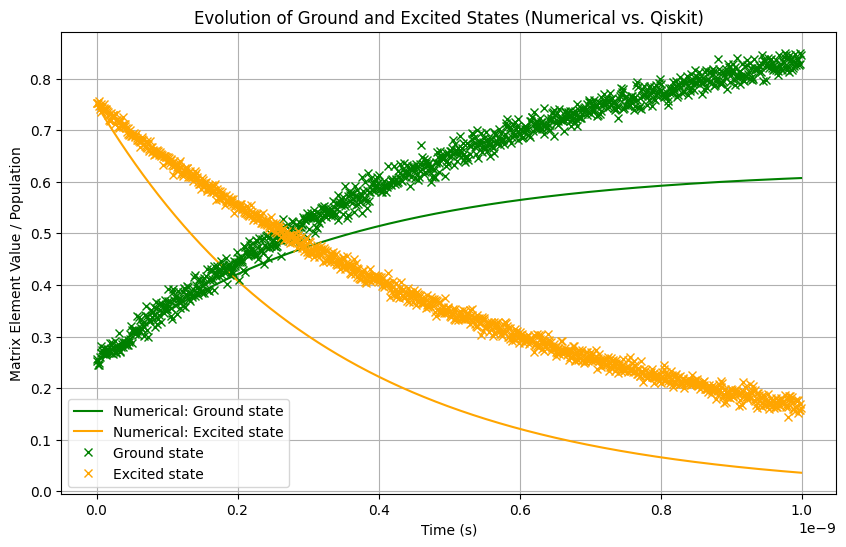

In [27]:
#plotting the QASM simulation results
time_array_QASM = np.arange(0, 1000, 1)
time_steps = [i * delta_t for i in range(n_steps)]

# Plotting
plt.figure(figsize=(10, 6))

# Plot the results from the Kraus operators
plt.plot(time_steps, elements_00, label="Numerical: Ground state", color = "green", markersize=4)
plt.plot(time_steps, elements_11, label="Numerical: Excited state", color = "orange", markersize=4)

plt.plot(time_steps, p_ground, marker = "x", linestyle="None", color = "green", label="Ground state")
plt.plot(time_steps, p_excited, marker = "x", linestyle="None", color = "orange", label='Excited state')

plt.xlabel("Time (s)")
plt.ylabel("Matrix Element Value / Population")
plt.title("Evolution of Ground and Excited States (Numerical vs. Qiskit)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot the results from the Kraus operators
plt.plot(time_steps, elements_00, label="Numerical: Ground state", color = "green", markersize=4)
plt.plot(time_steps, elements_11, label="Numerical: Excited state", color = "orange", markersize=4)

# Plot the results from Qiskit simulations
plt.plot(time_steps, p_ground, label="Qiskit: Ground state", marker = "x", linestyle="None", color = "green", markersize=4)
plt.plot(time_steps, p_excited, label="Qiskit: Excited state", marker = "x", linestyle="None", color = "orange", markersize=4)

# Configure the plot
plt.xlabel("Time (s)")
plt.ylabel("Matrix Element Value / Population")
plt.title("Evolution of Ground and Excited States (Numerical vs. Qiskit)")
plt.legend()
plt.grid()
plt.show()

Statevector([ 7.07106781e-01+0.j,  3.33279482e-01+0.j, -6.07765483e-17+0.j,
              6.23638346e-01+0.j],
            dims=(2, 2))


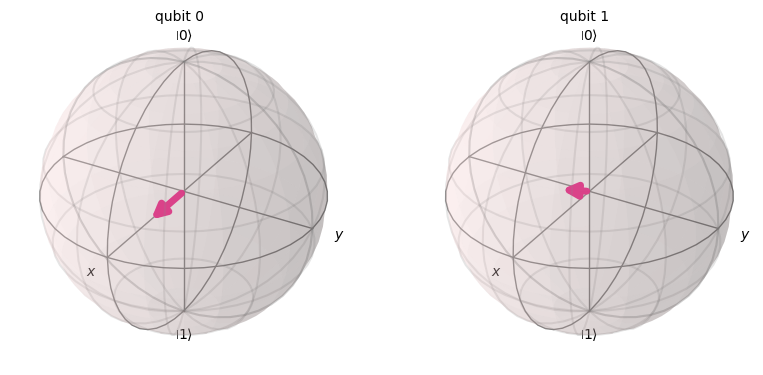

In [6]:
from qiskit import *
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

def u0v1_instructional(qc: QuantumCircuit):

    qc.u(-1.08,0,0,1)
    qc.h(1)
    qc.cx(1,0)
    qc.h(1)
    qc.u(1.08,0,0,1)
    qc.h(1)
    qc.cx(1,0)
    qc.h(1)
    qc.h(0)
    qc.z(1)
    return qc

simulator_statevector = AerSimulator(method="statevector")

qc = QuantumCircuit(2,2)
qc = u0v1_instructional(qc)
state = Statevector.from_instruction(qc)
print(state)
plot_bloch_multivector(state)

                          ┌───┐                         ┌───┐┌───┐     ┌─┐   
q_0: ─────────────────────┤ X ├─────────────────────────┤ X ├┤ H ├─────┤M├───
     ┌──────────────┐┌───┐└─┬─┘┌───┐┌─────────────┐┌───┐└─┬─┘├───┤┌───┐└╥┘┌─┐
q_1: ┤ U(-1.08,0,0) ├┤ H ├──■──┤ H ├┤ U(1.08,0,0) ├┤ H ├──■──┤ H ├┤ Z ├─╫─┤M├
     └──────────────┘└───┘     └───┘└─────────────┘└───┘     └───┘└───┘ ║ └╥┘
c: 2/═══════════════════════════════════════════════════════════════════╩══╩═
                                                                        0  1 


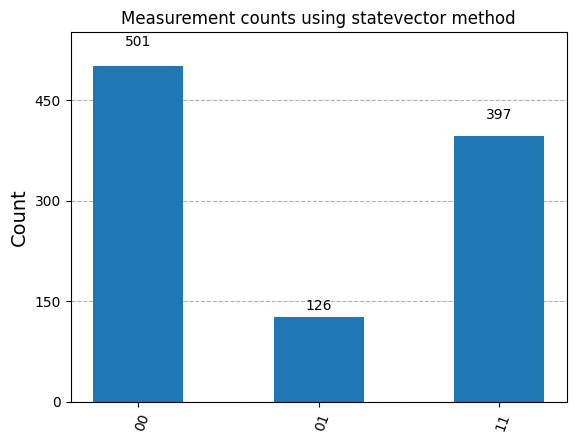

In [7]:
qc.measure(0,0)
qc.measure(1,1)
print(qc.draw())

qc_statevector = transpile(qc, simulator_statevector)

run_statevector = simulator_statevector.run(qc_statevector, shots=1024)

result_statevector = run_statevector.result()

counts_statevector = result_statevector.get_counts(qc_statevector)

plot_histogram(counts_statevector, title="Measurement counts using statevector method")